# **BRAIN TUMOR MRI MULTI-CLASS CLASSIFICATION USING DEEP LEARNING**
- authored by Satrajit Kar, MESE@JU'25
- [Brain Tumor MRI Dataset (SARTAJ+Br35H+figshare)]

Import files and modules

In [1]:
from google.colab import files
print("Upload your kaggle.json")
uploaded = files.upload()

Upload your kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [4]:
import shutil
import os
dir_train = '/content/Training'
dir_test = '/content/Testing'
new_dir = '/content/brain-tumor-classification-mri'
os.makedirs(new_dir, exist_ok=True)
shutil.move(dir_train, new_dir)
shutil.move(dir_test, new_dir)

'/content/brain-tumor-classification-mri/Testing'

In [5]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


Data Preprocessing
- Sample Image in Each Stage of Data Preprocessing

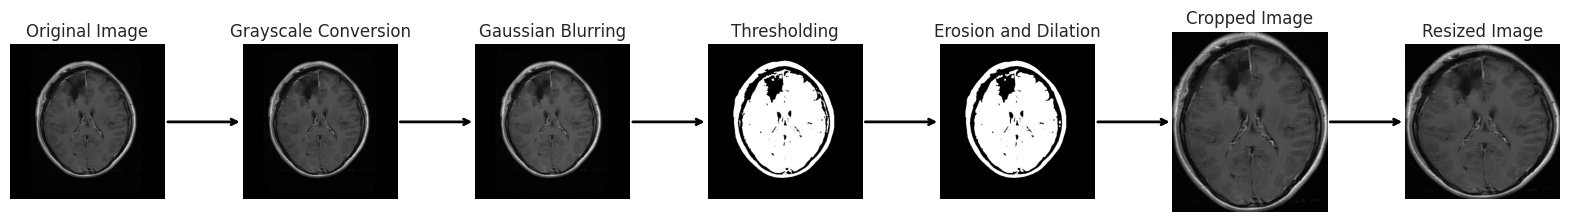

In [6]:
import numpy as np
import cv2
import os
import imutils
import matplotlib.pyplot as plt

def crop_img(img, save_path):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    fig, axs = plt.subplots(1, 7, figsize=(20, 20))

    # Stage 0: Show Original Image
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')

    # Stage 1: Grayscale Conversion
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    cv2.imwrite(save_path + '/grayscale1.png', gray)
    axs[1].imshow(gray, cmap='gray')
    axs[1].set_title('Grayscale Conversion')

    # Stage 2: Gaussian Blurring
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    cv2.imwrite(save_path + '/gaussian_blurred2.png', gray)
    axs[2].imshow(gray, cmap='gray')
    axs[2].set_title('Gaussian Blurring')

    # Stage 3: Thresholding
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite(save_path + '/thresholded3.png', thresh)
    axs[3].imshow(thresh, cmap='gray')
    axs[3].set_title('Thresholding')

    # Stage 4: Erosion and Dilation
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cv2.imwrite(save_path + '/eroded_dilated4.png', thresh)
    axs[4].imshow(thresh, cmap='gray')
    axs[4].set_title('Erosion and Dilation')

    # Stage 5: Contour Detection
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Stage 6: Extreme Point Detection and Image Cropping
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    cv2.imwrite(save_path + '/cropped5.png', new_img)
    axs[5].imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    axs[5].set_title('Cropped Image')

    # Stage 7: Resizing
    new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
    cv2.imwrite(save_path + '/resized6.png', new_img)
    axs[6].imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    axs[6].set_title('Resized Image')

    # Draw arrows
    for i in range(6):
        axs[i].annotate("", xy=(1, 0.5), xytext=(0, 0.5),
                        xycoords=axs[i].transAxes, textcoords=axs[i+1].transAxes,
                        arrowprops=dict(arrowstyle="<-", linewidth=2, color = 'black'))
        axs[i].axis('off')
    axs[6].axis('off')

    #Adjust spacing between subplots

    plt.subplots_adjust(wspace=0.5)

    plt.show()

    return new_img

if __name__ == "__main__":
    training = "/content/brain-tumor-classification-mri/Training"
    IMG_SIZE = 256

    dir = 'glioma'  # select the class
    path = os.path.join(training,dir)
    image_dir = os.listdir(path)
    img = image_dir[0]  # select the first image
    image = cv2.imread(os.path.join(path,img))
    img_save_path = '/content/data_preprocessing/' + dir + '/' + img.split('.')[0]  # create a new folder for the image
    if not os.path.exists(img_save_path):
        os.makedirs(img_save_path)
    cv2.imwrite(img_save_path + '/original.png', image)  # save the original image
    new_img = crop_img(image, img_save_path)
    new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
    cv2.imwrite(img_save_path + '/Resized.png', new_img)


Data Cleaning

In [7]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import imutils

def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

if __name__ == "__main__":
	training = "/content/brain-tumor-classification-mri/Training"
	testing = "/content/brain-tumor-classification-mri/Testing"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = '/content/cleaned/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

	for dir in testing_dir:
		save_path = '/content/cleaned/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

In [8]:
# Generate data paths with labels
train_data_dir = '/content/cleaned/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [9]:
train_df

,filepaths,labels
0,/content/cleaned/Training/notumor/Tr-no_0623.jpg,notumor
1,/content/cleaned/Training/notumor/Tr-no_0214.jpg,notumor
2,/content/cleaned/Training/notumor/Tr-no_1094.jpg,notumor
3,/content/cleaned/Training/notumor/Tr-no_0517.jpg,notumor
4,/content/cleaned/Training/notumor/Tr-no_0017.jpg,notumor
...,...,...
5707,/content/cleaned/Training/glioma/Tr-gl_1183.jpg,glioma
5708,/content/cleaned/Training/glioma/Tr-gl_1298.jpg,glioma
5709,/content/cleaned/Training/glioma/Tr-gl_0099.jpg,glioma
5710,/content/cleaned/Training/glioma/Tr-gl_0137.jpg,glioma


In [10]:
# Generate data paths with labels
test_data_dir = '/content/cleaned/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [11]:
ts_df

,filepaths,labels
0,/content/cleaned/Testing/notumor/Te-no_0149.jpg,notumor
1,/content/cleaned/Testing/notumor/Te-no_0020.jpg,notumor
2,/content/cleaned/Testing/notumor/Te-no_0386.jpg,notumor
3,/content/cleaned/Testing/notumor/Te-no_0167.jpg,notumor
4,/content/cleaned/Testing/notumor/Te-no_0323.jpg,notumor
...,...,...
1306,/content/cleaned/Testing/glioma/Te-gl_0104.jpg,glioma
1307,/content/cleaned/Testing/glioma/Te-gl_0163.jpg,glioma
1308,/content/cleaned/Testing/glioma/Te-gl_0041.jpg,glioma
1309,/content/cleaned/Testing/glioma/Te-gl_0268.jpg,glioma


train, validation and test split

In [12]:
# valid and test dataframe
train_df, valid_df = train_test_split(train_df,  train_size= 0.8, shuffle= True, random_state= 123)

In [13]:
# cropped image size
batch_size = 16
img_size = (256,256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( ts_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


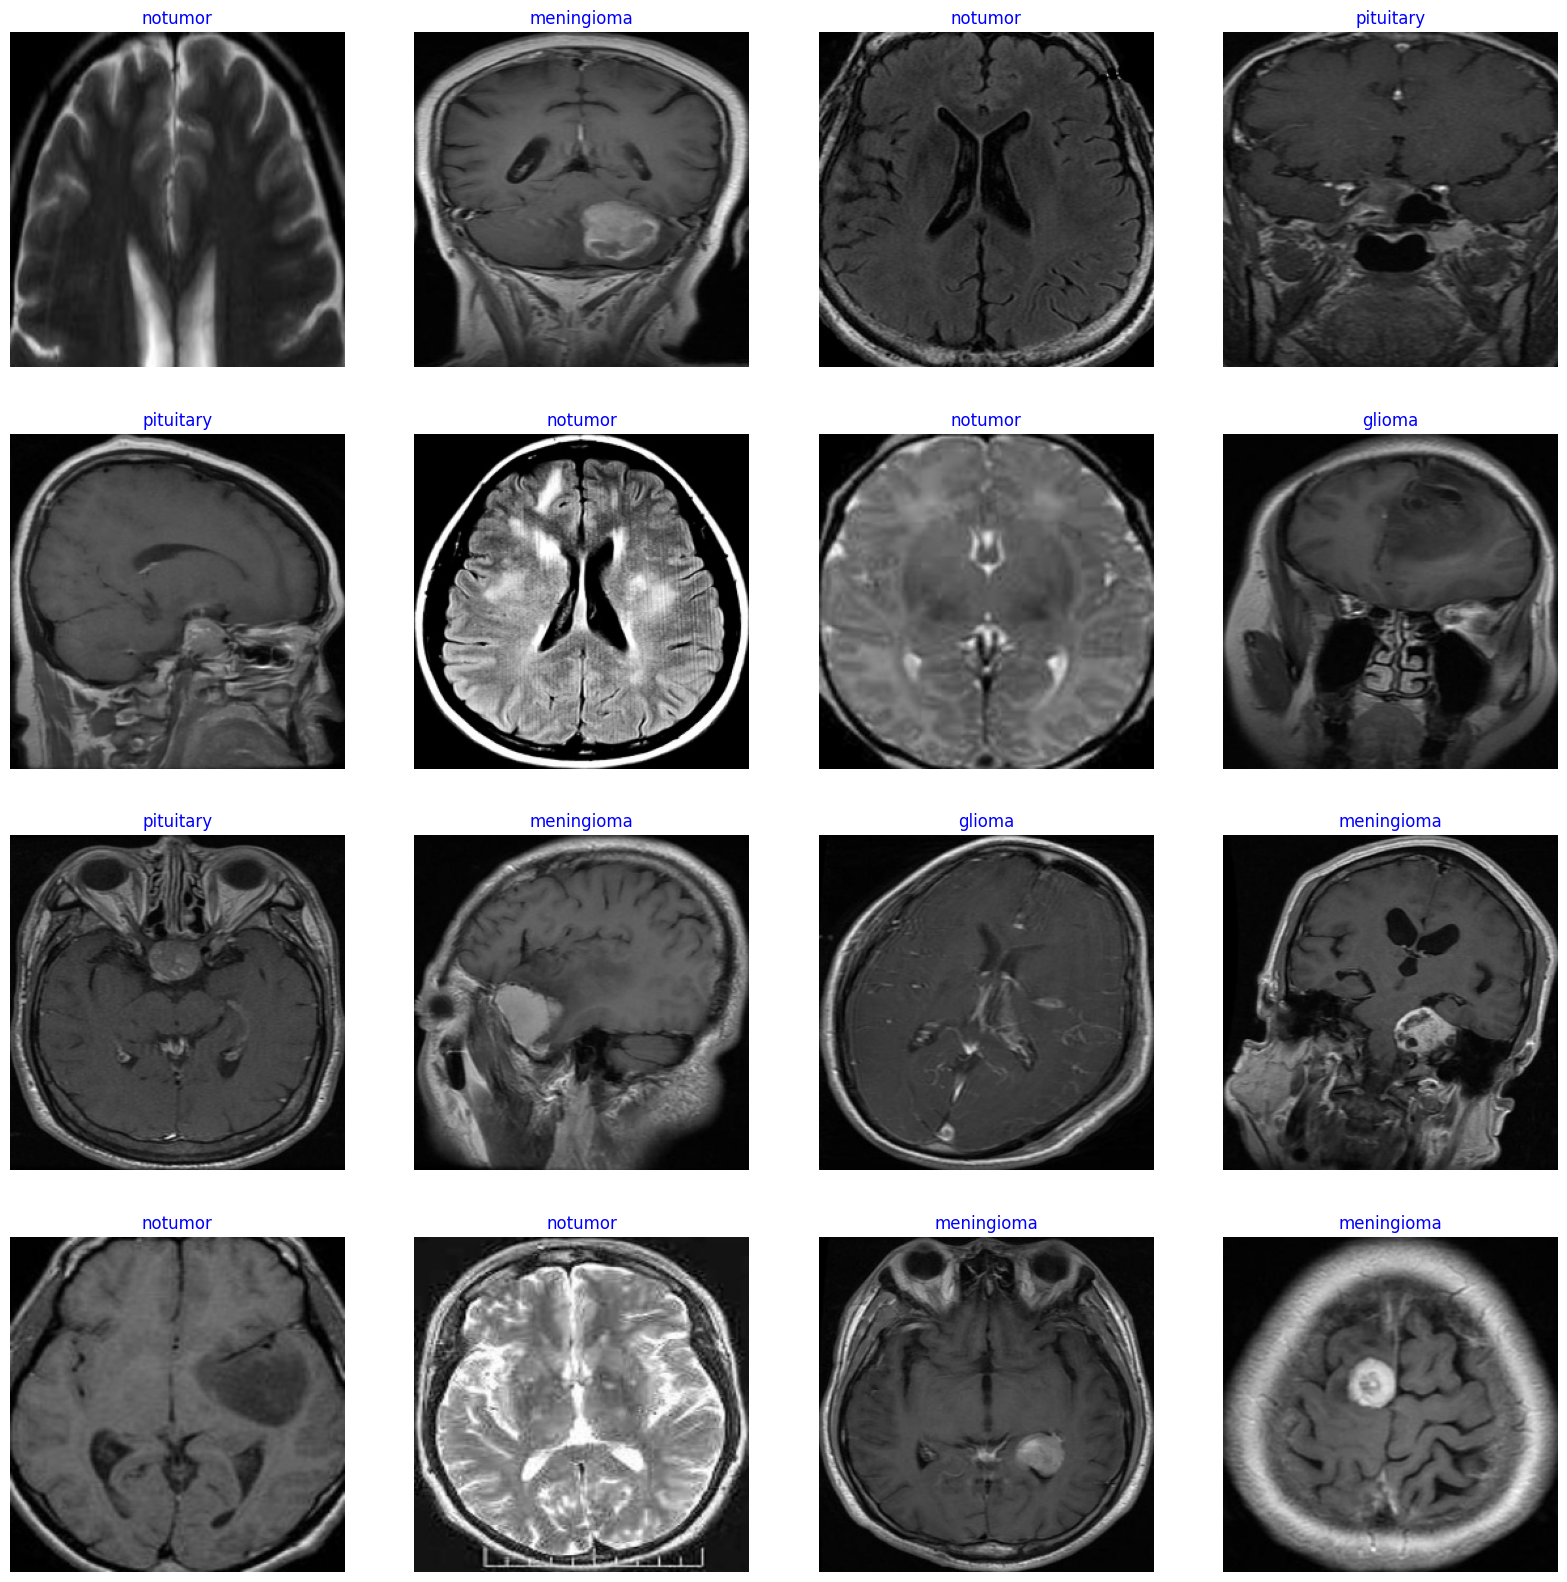

In [14]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

EfficientNetB3 Model

In [15]:
from tensorflow.keras.applications import EfficientNetB3

# Create Model Structure
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


base_model = tf.keras.applications.EfficientNetB3(include_top= False, weights= 'imagenet', input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

In [16]:
history = model.fit(x= train_gen, epochs= 30, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/30
286/286 [==============================] - 163s 369ms/step - loss: 6.2203 - accuracy: 0.8518 - val_loss: 4.5108 - val_accuracy: 0.9169
Epoch 2/30
286/286 [==============================] - 101s 353ms/step - loss: 3.4517 - accuracy: 0.9451 - val_loss: 2.6177 - val_accuracy: 0.9536
Epoch 3/30
286/286 [==============================] - 105s 369ms/step - loss: 2.0013 - accuracy: 0.9726 - val_loss: 1.4658 - val_accuracy: 0.9825
Epoch 4/30
286/286 [==============================] - 106s 369ms/step - loss: 1.1672 - accuracy: 0.9845 - val_loss: 0.9117 - val_accuracy: 0.9816
Epoch 5/30
286/286 [==============================] - 101s 352ms/step - loss: 0.7328 - accuracy: 0.9882 - val_loss: 0.5737 - val_accuracy: 0.9816
Epoch 6/30
286/286 [==============================] - 101s 353ms/step - loss: 0.4928 - accuracy: 0.9893 - val_loss: 0.3998 - val_accuracy: 0.9851
Epoch 7/30
286/286 [==============================] - 101s 352ms/step - loss: 0.3585 - accuracy: 0.9882 - val_loss: 0.3213 -

In [17]:
model.save_weights("/content/efficientnetb3_braintumor_weights.h5")

In [18]:
import pandas as pd

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame(history.history)

# Use the DataFrame's 'to_string' method to print the DataFrame in a tabular format
print(history_df.to_string())

        loss  accuracy  val_loss  val_accuracy
0   6.220334  0.851828  4.510787      0.916885
1   3.451678  0.945065  2.617715      0.953631
2   2.001338  0.972642  1.465754      0.982502
3   1.167184  0.984460  0.911704      0.981627
4   0.732804  0.988181  0.573653      0.981627
5   0.492787  0.989276  0.399836      0.985127
6   0.358540  0.988181  0.321319      0.980752
7   0.272901  0.992121  0.231654      0.989501
8   0.215949  0.994528  0.191572      0.991251
9   0.184907  0.994966  0.198025      0.985127
10  0.167759  0.994309  0.179478      0.986877
11  0.151314  0.996717  0.171314      0.984252
12  0.144117  0.996498  0.158889      0.986877
13  0.135235  0.996717  0.159341      0.986002
14  0.124727  0.998249  0.158541      0.984252
15  0.117746  0.998468  0.153529      0.984252
16  0.121772  0.994966  0.157930      0.986002
17  0.115249  0.997592  0.143239      0.987752
18  0.109480  0.997155  0.131972      0.989501
19  0.110897  0.996717  0.144541      0.987752
20  0.097050 

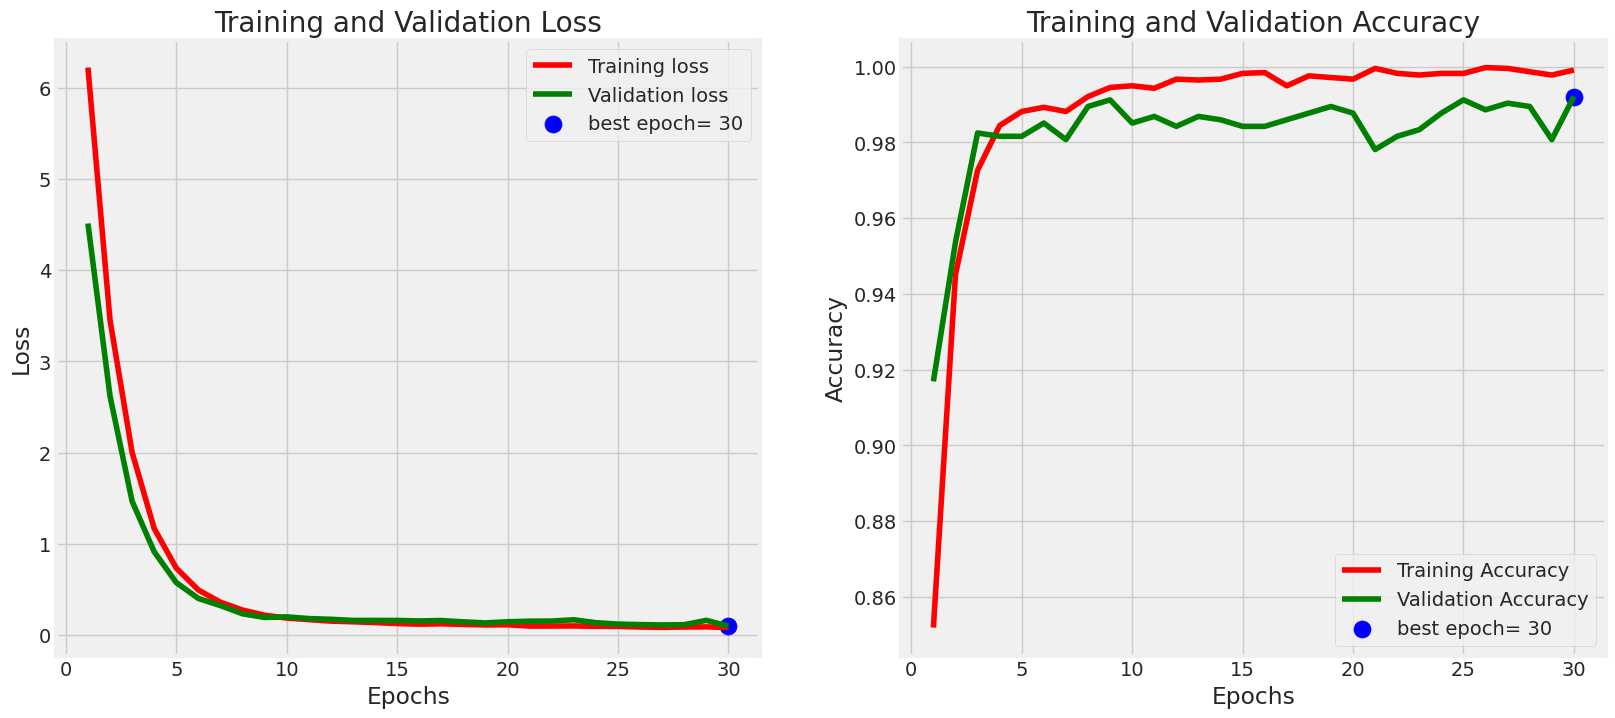

In [19]:
#Plot the model's performance

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [20]:
# Test its accuracy

ts_length = len(ts_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

19/19 [==============================] - 2s 79ms/step - loss: 0.0590 - accuracy: 1.0000
Train Loss:  0.06880643218755722
Train Accuracy:  1.0
--------------------
Validation Loss:  0.07018621265888214
Validation Accuracy:  0.9967105388641357
--------------------
Test Loss:  0.058962296694517136
Test Accuracy:  1.0


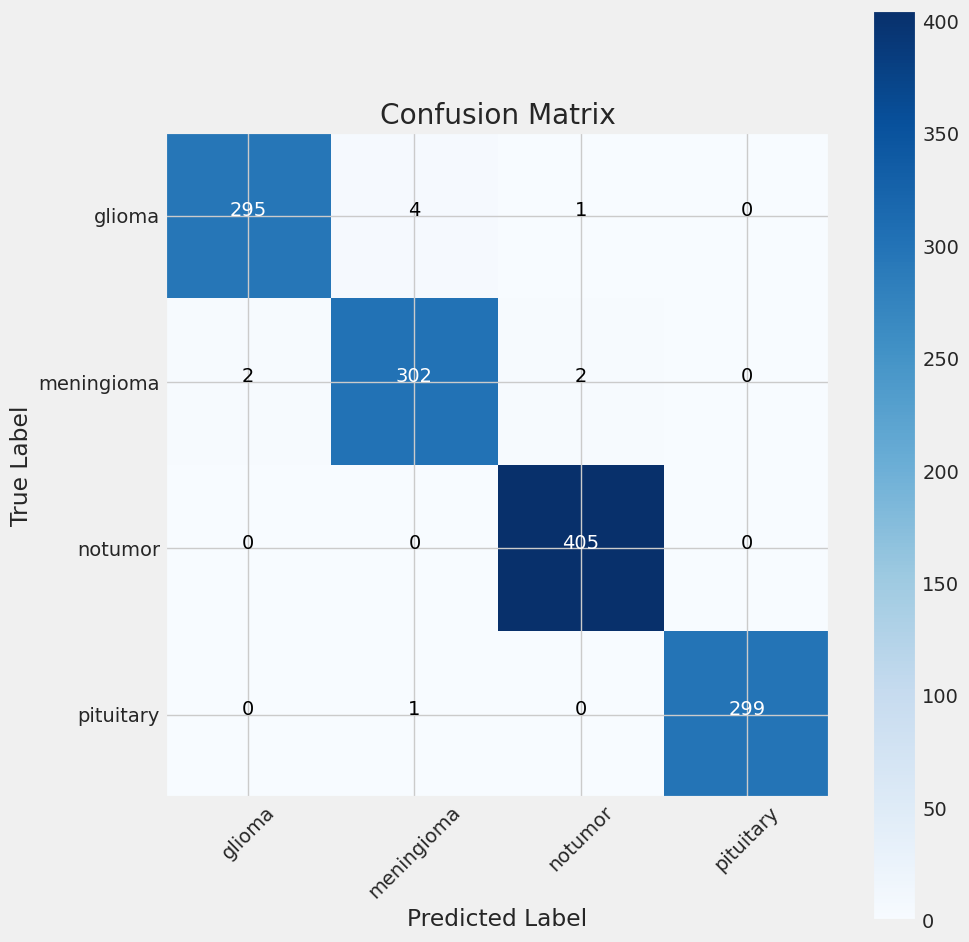

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.98      0.99      0.99       306
     notumor       0.99      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [21]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


print(classification_report(test_gen.classes, y_pred, target_names= classes))

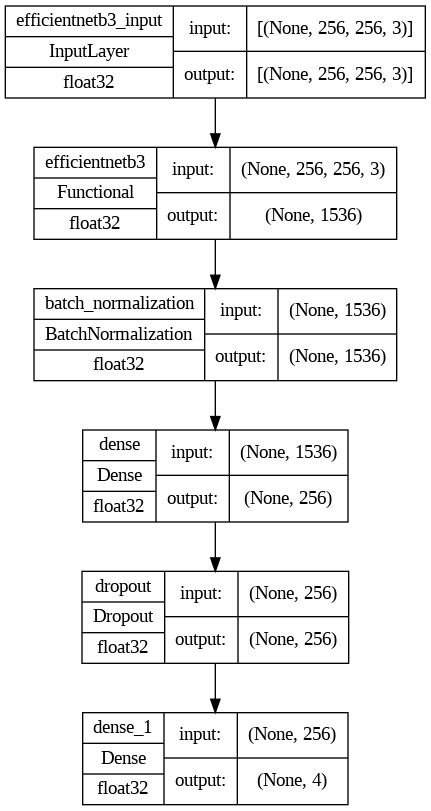

In [22]:
!pip install pydot graphviz

# Import necessary modules
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_visual = models.Model(inputs=model.input, outputs=model.output)

# Save model architecture to a file
plot_model(model_visual, show_dtype=True, to_file='efficientnetb3_model_architecture.png', show_shapes=True)

# Display model architecture in the notebook
Image(retina=True, filename='efficientnetb3_model_architecture.png')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 8.4 MB/s eta 0:00:00


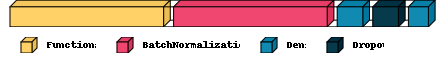

In [23]:
!pip install visualkeras

from visualkeras import layered_view
# Visualize the model
layered_view(model, legend=True, max_xy=300)

Feature Extraction using Pretrained Model Weights

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
import os
import pandas as pd
import numpy as np

# Load the EfficientNetB3 model
base_model_efnetb3 = EfficientNetB3(include_top=False, input_shape=(256, 256, 3))
base_model_efnetb3.load_weights('/content/efficientnetb3_braintumor_weights.h5', by_name=True)

x = base_model_efnetb3.output
x = GlobalAveragePooling2D()(x)
feature_extraction_model = Model(inputs=base_model_efnetb3.input, outputs=x)

labels = {'glioma':1,'notumor':0,'meningioma':2,'pituitary':3}
training_global_average_pool_2d_efnetb3 = []
testing_global_average_pool_2d_efnetb3 = []


In [25]:
main_folder = '/content/brain-tumor-classification-mri/Training'
total_files=1
subfiles=1
# Iterate through subfolders and print subfolder name and file names
for root, dirs, files in os.walk(main_folder):
  print(total_files)
  for file in files:
    if file.endswith(('jpg', 'jpeg', 'png')):
      d=[]
      file_path = os.path.join(root, file)  # Check for image file formats
      img = image.load_img(file_path, target_size=(256, 256))
      img_array = image.img_to_array(img)
      img_array = np.expand_dims(img_array, axis=0)
      processed_img = preprocess_input(img_array)
      global_average_features = feature_extraction_model.predict(processed_img)
      one_dim_list = np.array(global_average_features).flatten()
      sub_folder_name=os.path.basename(root)
      ch=labels[sub_folder_name]
      d.append(sub_folder_name+'_'+file)
      d.extend(one_dim_list)
      d.append(ch)
      training_global_average_pool_2d_efnetb3.append(d)
      subfiles+=1
      total_files+=1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 49ms/step
1596
1/1 [==============================] - 0s 75ms/step
2935
1/1 [==============================] - 0s 34ms/step
4392
1/1 [==============================] - 0s 32ms/step


In [26]:
training_df=pd.DataFrame(training_global_average_pool_2d_efnetb3)

In [27]:
training_df

,0,1,2,3,4,5,6,7,8,9,...,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537
0,notumor_Tr-no_0623.jpg,-0.221680,-0.040301,-0.076835,0.549545,0.208304,-0.012086,0.017784,0.679654,-0.245546,...,-0.220204,-0.190397,-0.008247,0.360298,0.566315,-0.189374,-0.193046,-0.156906,-0.001254,0
1,notumor_Tr-no_0214.jpg,0.148370,0.546420,-0.094851,0.257357,0.290810,0.208732,0.191621,0.976839,-0.213190,...,0.347711,-0.137956,0.298238,0.735912,0.507443,-0.186587,0.181245,-0.126695,-0.103711,0
2,notumor_Tr-no_1094.jpg,-0.186093,0.082735,0.060711,0.774781,0.254981,-0.253685,-0.031761,0.553888,-0.238560,...,0.070675,-0.228900,-0.188679,0.212338,1.039073,-0.129296,-0.125074,-0.201436,-0.212102,0
3,notumor_Tr-no_0517.jpg,-0.159257,0.107217,0.365542,0.972605,0.348853,0.373078,-0.081703,0.574996,-0.184282,...,-0.190259,-0.171311,0.012656,0.457130,0.439953,-0.211548,-0.164567,-0.165214,-0.068299,0
4,notumor_Tr-no_0017.jpg,-0.212494,-0.140216,-0.176833,1.008130,0.021190,0.961172,0.168117,0.911770,-0.187316,...,-0.084220,-0.171400,0.603215,-0.027259,-0.235506,-0.179597,-0.237247,-0.168362,-0.167231,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5707,glioma_Tr-gl_1183.jpg,-0.005890,-0.004772,-0.204658,0.147482,0.014179,0.108145,0.741322,0.654036,-0.118996,...,0.286569,-0.145382,0.224950,-0.098668,0.479492,-0.055185,-0.070296,-0.165341,-0.135515,1
5708,glioma_Tr-gl_1298.jpg,-0.156412,-0.207819,-0.131443,0.732431,0.229673,0.334883,0.260407,1.276892,-0.212167,...,-0.214383,-0.190773,1.075743,0.162040,-0.202072,-0.223960,-0.232007,-0.189514,-0.092252,1
5709,glioma_Tr-gl_0099.jpg,-0.180916,0.005998,-0.171712,0.563885,-0.146090,0.377435,-0.140006,1.320578,-0.158411,...,0.788799,-0.163002,0.403614,0.204145,0.014816,0.019599,-0.203184,-0.118708,-0.173419,1
5710,glioma_Tr-gl_0137.jpg,-0.205313,-0.206366,0.016052,0.463411,0.075184,-0.109457,0.164158,1.209493,-0.233934,...,-0.023451,-0.230932,-0.224280,-0.128554,0.203454,-0.150289,-0.156452,-0.208402,-0.158552,1


In [28]:
main_folder = '/content/brain-tumor-classification-mri/Testing'
total_files=1
subfiles=1
# Iterate through subfolders and print subfolder name and file names
for root, dirs, files in os.walk(main_folder):
  print(total_files)
  for file in files:
    if file.endswith(('jpg', 'jpeg', 'png')):
      d=[]
      file_path = os.path.join(root, file)  # Check for image file formats
      img = image.load_img(file_path, target_size=(256, 256))
      img_array = image.img_to_array(img)
      img_array = np.expand_dims(img_array, axis=0)
      processed_img = preprocess_input(img_array)
      global_average_features = feature_extraction_model.predict(processed_img)
      one_dim_list = np.array(global_average_features).flatten()
      sub_folder_name=os.path.basename(root)
      ch=labels[sub_folder_name]
      d.append(sub_folder_name+'_'+file)
      d.extend(one_dim_list)
      d.append(ch)
      testing_global_average_pool_2d_efnetb3.append(d)
      subfiles+=1
      total_files+=1

1
1
1/1 [==============================] - 0s 29ms/step
406
1/1 [==============================] - 0s 43ms/step
712
1/1 [==============================] - 0s 28ms/step
1012
1/1 [==============================] - 0s 29ms/step


In [29]:
testing_df=pd.DataFrame(testing_global_average_pool_2d_efnetb3)

In [30]:
testing_df

,0,1,2,3,4,5,6,7,8,9,...,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537
0,notumor_Te-no_0149.jpg,-0.196272,-0.135956,0.105662,0.605828,-0.041294,0.010216,0.132938,1.111722,-0.237702,...,0.381500,-0.191512,0.144105,-0.073290,0.340994,-0.164696,-0.225545,-0.130824,0.033793,0
1,notumor_Te-no_0020.jpg,-0.201751,-0.092027,-0.219333,0.735620,-0.019386,-0.147276,0.436315,0.405446,-0.205960,...,0.487031,-0.182678,-0.155691,-0.201353,-0.156753,-0.105211,-0.186567,-0.160564,-0.077292,0
2,notumor_Te-no_0386.jpg,-0.229658,-0.085807,-0.183871,1.215165,-0.087322,0.068511,0.829228,1.575344,-0.246151,...,-0.183376,-0.219395,0.556426,0.254939,-0.159070,-0.210740,0.030612,-0.159018,-0.031769,0
3,notumor_Te-no_0167.jpg,-0.208918,-0.108381,-0.190288,1.647927,0.224494,0.282055,0.048950,1.199857,-0.218005,...,-0.207500,-0.207515,0.283431,0.479392,-0.218870,-0.255045,-0.172038,-0.149298,-0.147237,0
4,notumor_Te-no_0323.jpg,-0.166958,-0.104319,0.063750,1.101480,0.604246,0.324820,0.581901,1.981383,-0.001565,...,0.019312,-0.224587,-0.186951,0.284579,0.336221,0.011308,0.020394,-0.131768,-0.172632,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,glioma_Te-gl_0104.jpg,-0.162758,-0.139681,-0.008345,0.937953,0.826342,-0.178641,0.121662,1.090821,-0.237926,...,0.349166,-0.225939,0.004933,0.119283,-0.254594,-0.210678,-0.137206,-0.057239,-0.145928,1
1307,glioma_Te-gl_0163.jpg,0.323243,-0.237122,-0.210275,0.026029,0.062538,0.843305,0.685153,-0.214939,-0.031888,...,-0.033671,-0.135122,-0.003846,0.184649,-0.104944,-0.114058,-0.198282,-0.197943,0.676436,1
1308,glioma_Te-gl_0041.jpg,-0.111825,0.401928,-0.157390,0.408406,-0.191654,0.040223,0.275288,0.824178,-0.206872,...,0.584765,-0.100350,0.937160,0.084365,0.555165,-0.201741,0.183891,-0.142528,-0.144176,1
1309,glioma_Te-gl_0268.jpg,0.295203,0.227312,-0.144019,0.058919,0.183280,-0.199185,0.028842,0.509839,-0.101434,...,0.376090,-0.016049,0.341435,0.009917,0.308386,-0.140097,-0.030893,-0.173123,-0.131088,1


In [31]:
from google.colab import files

# Save Testing DataFrame to a CSV file
testing_df.to_csv('testing_global_average_pool_2d_efnetb3_trained_weights_new.csv', index=False)

# Save Training DataFrame to a CSV file
training_df.to_csv('training_global_average_pool_2d_efnetb3_trained_weights_new.csv', index=False)

Finding Best Number of Reduced Features to be used for Mutual Information

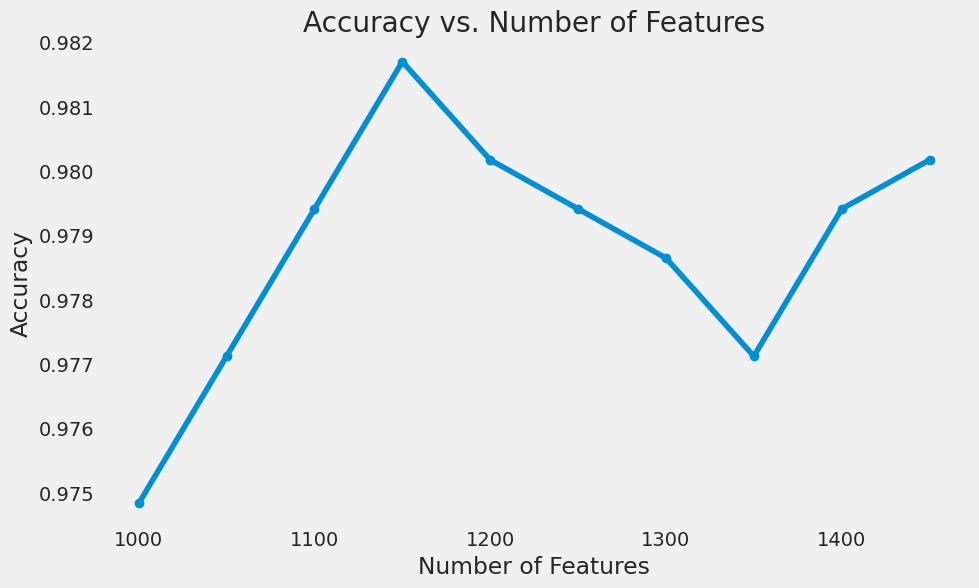

In [37]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the training dataset
df = pd.read_csv('/content/drive/MyDrive/BrainTumor/Final/training_global_average_pool_2d_efnetb3_trained_weights_new.csv')

# Separate features and target
X_train = df.iloc[:, 1:-1]
y_train = df.iloc[:, -1]

# Initialize the MinMaxScaler and apply it
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Initialize the SVM Classifier
clf = SVC(kernel='poly', gamma = 0.5, C = 0.1, random_state=7)

# Load the unseen testing dataset
df_test = pd.read_csv('/content/drive/MyDrive/BrainTumor/Final/testing_global_average_pool_2d_efnetb3_trained_weights_new.csv')

X_test = df_test.iloc[:, 1:-1]
y_test = df_test.iloc[:, -1]

X_test = scaler.transform(X_test)

# Define the range of k
k_values = range(1000, 1451, 50)

# Initialize a list to store accuracy for each k
accuracy_list = []

for k in k_values:
    # Apply Mutual Information for feature selection
    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_k = selector.fit_transform(X_train, y_train)
    X_test_k = selector.transform(X_test)

    # Train the model
    clf.fit(X_train_k, y_train)

    # Predict the labels of the test set
    y_pred = clf.predict(X_test_k)

    # Calculate accuracy and append to the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

# Plot the accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_list, marker='o', linestyle='-')
plt.title('Accuracy vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


SVM Classifier (Polynomial Kernel), without Mutual Information

SVM (Polynomial) 

              precision    recall  f1-score   support

     notumor       1.00      1.00      1.00       405
      glioma       0.99      0.94      0.96       300
  meningioma       0.94      0.98      0.96       306
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

Confusion Matrix 



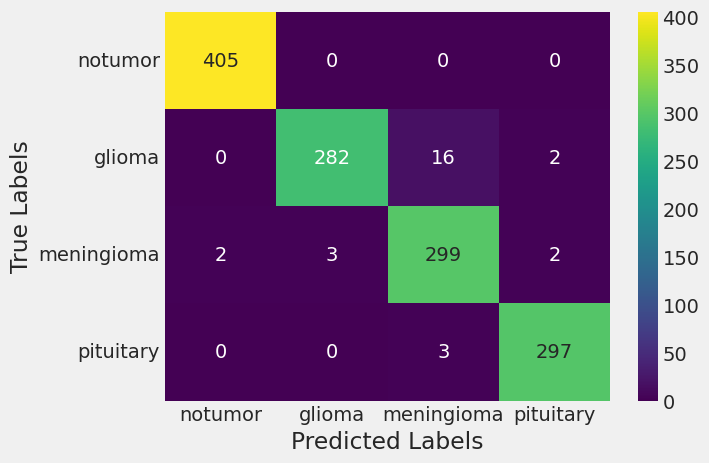


Accuracy SVM (Polynomial): 97.86 %


In [38]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the training dataset
df = pd.read_csv('/content/drive/MyDrive/BrainTumor/Final/training_global_average_pool_2d_efnetb3_trained_weights_new.csv')

# Separate features and target
X_train = df.iloc[:, 1:-1]
y_train = df.iloc[:, -1]

# Initialize the MinMaxScaler and apply it
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Initialize the SVM Classifier
clf = SVC(kernel='poly', gamma = 0.5, C = 0.1, random_state=7)

# Train the model
clf.fit(X_train, y_train)

# Load the unseen testing dataset
df_test = pd.read_csv('/content/drive/MyDrive/BrainTumor/Final/testing_global_average_pool_2d_efnetb3_trained_weights_new.csv')

X_test = df_test.iloc[:, 1:-1]
y_test = df_test.iloc[:, -1]

X_test = scaler.transform(X_test)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Define the class names
class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Print the classification report
print("SVM (Polynomial) \n")
print(classification_report(y_test, y_pred, target_names=class_names))

# Print the confusion matrix
print("Confusion Matrix \n")
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print('\nAccuracy SVM (Polynomial): {:.2f} %'.format(accuracy_score(y_test,y_pred)*100))


SVM Classifier (Polynomial Kernel), with Mutual Information

SVM (Polynomial) 

              precision    recall  f1-score   support

     notumor       1.00      1.00      1.00       405
      glioma       0.99      0.95      0.97       300
  meningioma       0.95      0.98      0.96       306
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

Confusion Matrix 



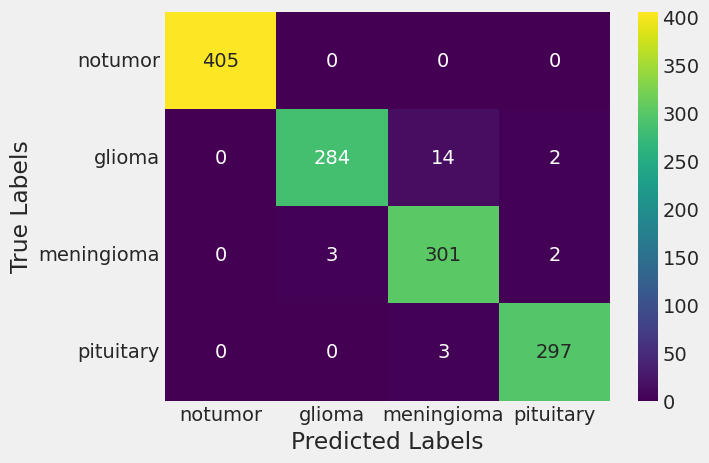


Accuracy SVM (Polynomial): 98.17 %


In [40]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the training dataset
df = pd.read_csv('/content/drive/MyDrive/BrainTumor/Final/training_global_average_pool_2d_efnetb3_trained_weights_new.csv')

# Separate features and target
X_train = df.iloc[:, 1:-1]
y_train = df.iloc[:, -1]

# Initialize the MinMaxScaler and apply it
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Apply Mutual Information for feature selection
selector = SelectKBest(mutual_info_classif, k=1140)
X_train = selector.fit_transform(X_train, y_train)

# Initialize the SVM Classifier
clf = SVC(kernel='poly', gamma = 0.5, C = 0.1, random_state=7)

# Train the model
clf.fit(X_train, y_train)

# Load the unseen testing dataset
df_test = pd.read_csv('/content/drive/MyDrive/BrainTumor/Final/testing_global_average_pool_2d_efnetb3_trained_weights_new.csv')

X_test = df_test.iloc[:, 1:-1]
y_test = df_test.iloc[:, -1]

X_test = scaler.transform(X_test)
X_test = selector.transform(X_test)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Define the class names
class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Print the classification report
print("SVM (Polynomial) \n")
print(classification_report(y_test, y_pred, target_names=class_names))

# Print the confusion matrix
print("Confusion Matrix \n")
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print('\nAccuracy SVM (Polynomial): {:.2f} %'.format(accuracy_score(y_test,y_pred)*100))

In [41]:
precision_per_class = precision_score(y_test, y_pred, average = None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred,average=None)

In [42]:
class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']
for i in range (len(precision_per_class)):
  print(f'Class: {class_names[i]} = Precision: {(precision_per_class[i]) * 100}, Recall = {(recall_per_class[i]) * 100}')

Class: notumor = Precision: 100.0, Recall = 100.0
Class: glioma = Precision: 98.95470383275261, Recall = 94.66666666666667
Class: meningioma = Precision: 94.65408805031447, Recall = 98.36601307189542
Class: pituitary = Precision: 98.67109634551495, Recall = 99.0


In [43]:
class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

for i in range(len(class_names)):
    accuracy = cm[i,i] / sum(cm[i,:])
    print(f'Class: {class_names[i]} = Accuracy: {accuracy * 100}, F1_Score = {(f1_per_class[i])*100}')

Class: notumor = Accuracy: 100.0, F1_Score = 100.0
Class: glioma = Accuracy: 94.66666666666667, F1_Score = 96.76320272572401
Class: meningioma = Accuracy: 98.36601307189542, F1_Score = 96.47435897435898
Class: pituitary = Accuracy: 99.0, F1_Score = 98.83527454242927


Visualization of Results

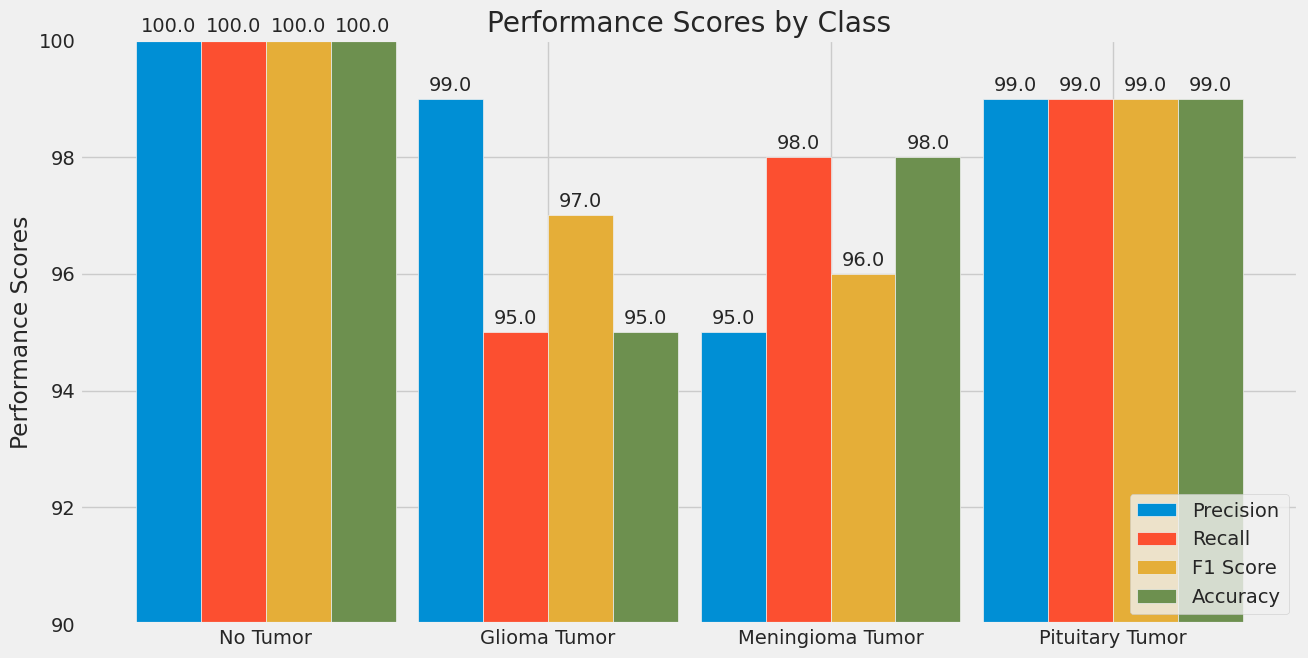

In [44]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Calculate metrics
precision_per_class = np.round(precision_score(y_test, y_pred, average=None), 2) * 100
recall_per_class = np.round(recall_score(y_test, y_pred, average=None), 2) * 100
f1_per_class = np.round(f1_score(y_test, y_pred,average=None), 2) * 100

# Calculate accuracy for each class
cm = confusion_matrix(y_test, y_pred)
accuracy_per_class = np.round([cm[i,i] / sum(cm[i,:]) for i in range(len(class_names))], 2) * 100

# Prepare data for bar plot
labels = ['No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']
x = np.arange(len(labels))  # the label locations
width = 0.23  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - 3*width/2, precision_per_class, width, label='Precision')
rects2 = ax.bar(x - width/2, recall_per_class, width, label='Recall')
rects3 = ax.bar(x + width/2, f1_per_class, width, label='F1 Score')
rects4 = ax.bar(x + 3*width/2, accuracy_per_class, width, label='Accuracy')

# Function to annotate bars with their respective values
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call autolabel function for each set of bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Scores')
ax.set_title('Performance Scores by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')  # Show legend beside the graph

# Increase the bottom margin to prevent x-labels from being cut-off
plt.subplots_adjust(bottom=0.15)

# Set y-axis limits to show values from 0.9 to 1.0
plt.ylim(90, 100)

plt.show()